# **NBA Player Stat Prediction Model** #
#### Date: 1-4-2025 ####
#### By: Daniel Davis ####

## **Intro** ##

Accurately predicting an NBA player's game performance is a challenging task that requires analyzing historical data, identifying key patterns, and leveraging advanced machine learning techniques. This project focuses on building a predictive model for NBA player stats using multiple machine learning algorithms, exploratory data analysis (EDA), and fine-tuning techniques to optimize performance. The approach begins with comprehensive data preprocessing, including feature engineering, followed by in-depth EDA to uncover trends and correlations. Several machine learning models, such as linear regression, decision trees, random forests, and neural networks, are trained and compared to determine the best-performing model. Hyperparameter tuning and cross-validation techniques are applied to refine predictions further. By integrating statistical analysis and machine learning, this project aims to develop a robust model that provides accurate and actionable insights into player performance, offering value to analysts, coaches, and sports enthusiasts.

### Import packages needed ###

In [71]:
!pip install nba_api
!pip install Torch

In [72]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
# Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
# NBA API for players game logs
from nba_api.stats.endpoints import playergamelog, commonplayerinfo
# NBA API to get specific players information
from nba_api.stats.static import players
# NBA API to get specific teams information
from nba_api.stats.static import teams
# Date library
from datetime import datetime
# PyTorch library
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### **Collect the dataset from API**

In [73]:
# Get player ID (replace with the desired player's name)
player_name = "Lebron James"

# Get player's information by inputing their name
player_obj = players.find_players_by_full_name(player_name)[0]

# Get the player's ID
player_id = player_obj["id"]

player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id)

# Getting the object of the player's draft year to set the bounds of the first year we need to start pulling their stats
draft_year = player_info.get_data_frames()[0]["FROM_YEAR"]

# Pulling the actual year from the object
draft_year = draft_year[0]

# Getting the object of the player's most current year to set the bounds when to stop making request to the api
to_year = player_info.get_data_frames()[0]["TO_YEAR"]

# Pulling the actual year from the object
to_year = to_year[0]

# Initialize an empty DataFrame
career_df = pd.DataFrame()

# This loop will collect all the games in a players NBA career
for i in range(draft_year,to_year+1):
    game_log = playergamelog.PlayerGameLog(player_id=player_id, season=i)
 
    game_log_df = game_log.get_data_frames()[0]
 
    career_df = pd.concat([career_df,game_log_df])

career_df




,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22003,2544,0020301179,"APR 14, 2004",CLE @ NYK,W,35,8,17,0.471,0,3,0.000,1,1,1.000,0,1,1,5,3,0,5,1,17,-6,0
1,22003,2544,0020301162,"APR 12, 2004",CLE vs. MIL,W,45,9,20,0.450,1,4,0.250,8,11,0.727,1,6,7,9,2,0,1,1,27,11,0
2,22003,2544,0020301151,"APR 10, 2004",CLE vs. MIA,W,32,4,11,0.364,0,2,0.000,2,5,0.400,1,2,3,11,0,0,2,3,10,14,0
3,22003,2544,0020301137,"APR 09, 2004",CLE @ MIA,L,42,6,14,0.429,1,1,1.000,11,15,0.733,1,6,7,8,1,0,8,2,24,-16,0
4,22003,2544,0020301128,"APR 07, 2004",CLE @ MEM,L,36,4,11,0.364,0,0,0.000,6,7,0.857,0,3,3,5,3,0,2,4,14,-11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,22024,2544,0022400118,"OCT 30, 2024",LAL @ CLE,L,29,9,13,0.692,1,3,0.333,7,7,1.000,1,5,6,3,0,0,6,2,26,-17,1
39,22024,2544,0022400111,"OCT 28, 2024",LAL @ PHX,L,36,3,14,0.214,2,5,0.400,3,6,0.500,0,5,5,8,1,0,2,1,11,-17,1
40,22024,2544,0022400096,"OCT 26, 2024",LAL vs. SAC,W,34,12,22,0.545,4,9,0.444,4,4,1.000,0,14,14,10,0,1,5,3,32,13,1
41,22024,2544,0022400085,"OCT 25, 2024",LAL vs. PHX,W,35,7,13,0.538,2,5,0.400,5,8,0.625,0,4,4,8,0,0,2,1,21,14,1


In [74]:
pd.set_option('display.max_columns', None)


### **Clean and Preprocess Dataset**

In [75]:
# Make a column with just the opposing teams name from the matchup column
career_df["OPP"] = career_df["MATCHUP"].str[-3:]

In [76]:
# Make nominal columns to numerical
career_df["HOME/AWAY"] = np.where(career_df["MATCHUP"].str.contains("@") == True, 1, 0)
career_df["Wins(1)/Lose(0)"] = np.where(career_df["WL"].str.contains("W") == True, 1, 0)

Need to collect a dataset from the API that has all of the teams in the NBA game ID so we can change the `OPP` column to numerical.

In [77]:
# Get team dataset from API
teams_data = teams.get_teams()
teams_df = pd.DataFrame(teams_data)
teams_df = teams_df.drop(columns=["full_name", "city", "state", "year_founded", "nickname"])
teams_df = teams_df.rename(columns={"abbreviation": "OPP"})

In [78]:
# Join the teams dataframe and career dataframes together on the OPP column to get teams ID
career_df = pd.merge(career_df, teams_df, on='OPP')
career_df = career_df.rename(columns={'id_x': "OPP_ID"})

In [79]:
# This function converts a string date to numerical
def numericDate(date):
    date_object = datetime.strptime(date, "%b %d, %Y")
    formatted_date = date_object.strftime("%m%d%Y")
    return formatted_date

# Use the function (numericDate) and apply it on the GAME_DATE column
career_df["DATE"] = career_df["GAME_DATE"].apply(numericDate)

In [80]:
career_df = career_df.rename(columns={"id": "OPP_ID", "HOME/AWAY": "HOME(0)/AWAY(1)"})

In [81]:
numeric_career_df = career_df[["SEASON_ID", "Player_ID", "Game_ID", 
                         "DATE", "OPP_ID", "HOME(0)/AWAY(1)", "Wins(1)/Lose(0)", 
                        "MIN", "FGM", "FGA", "FG_PCT", "FG3M",	"FG3A",	"FG3_PCT", "FTM", "FTA", "FT_PCT", "OREB", 
                        "DREB", "REB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "PLUS_MINUS"]]

### **Correlation matrix**

I use the correlation matrix to identfy the potential relationships or associations between different features in the dataset. Also helps me determine which features to drop from the dataset. I will drop every feature in the dataset that has a correlation coefficient < 0.4 on the `PTS` row. 

The following code generates a correlation matrix.


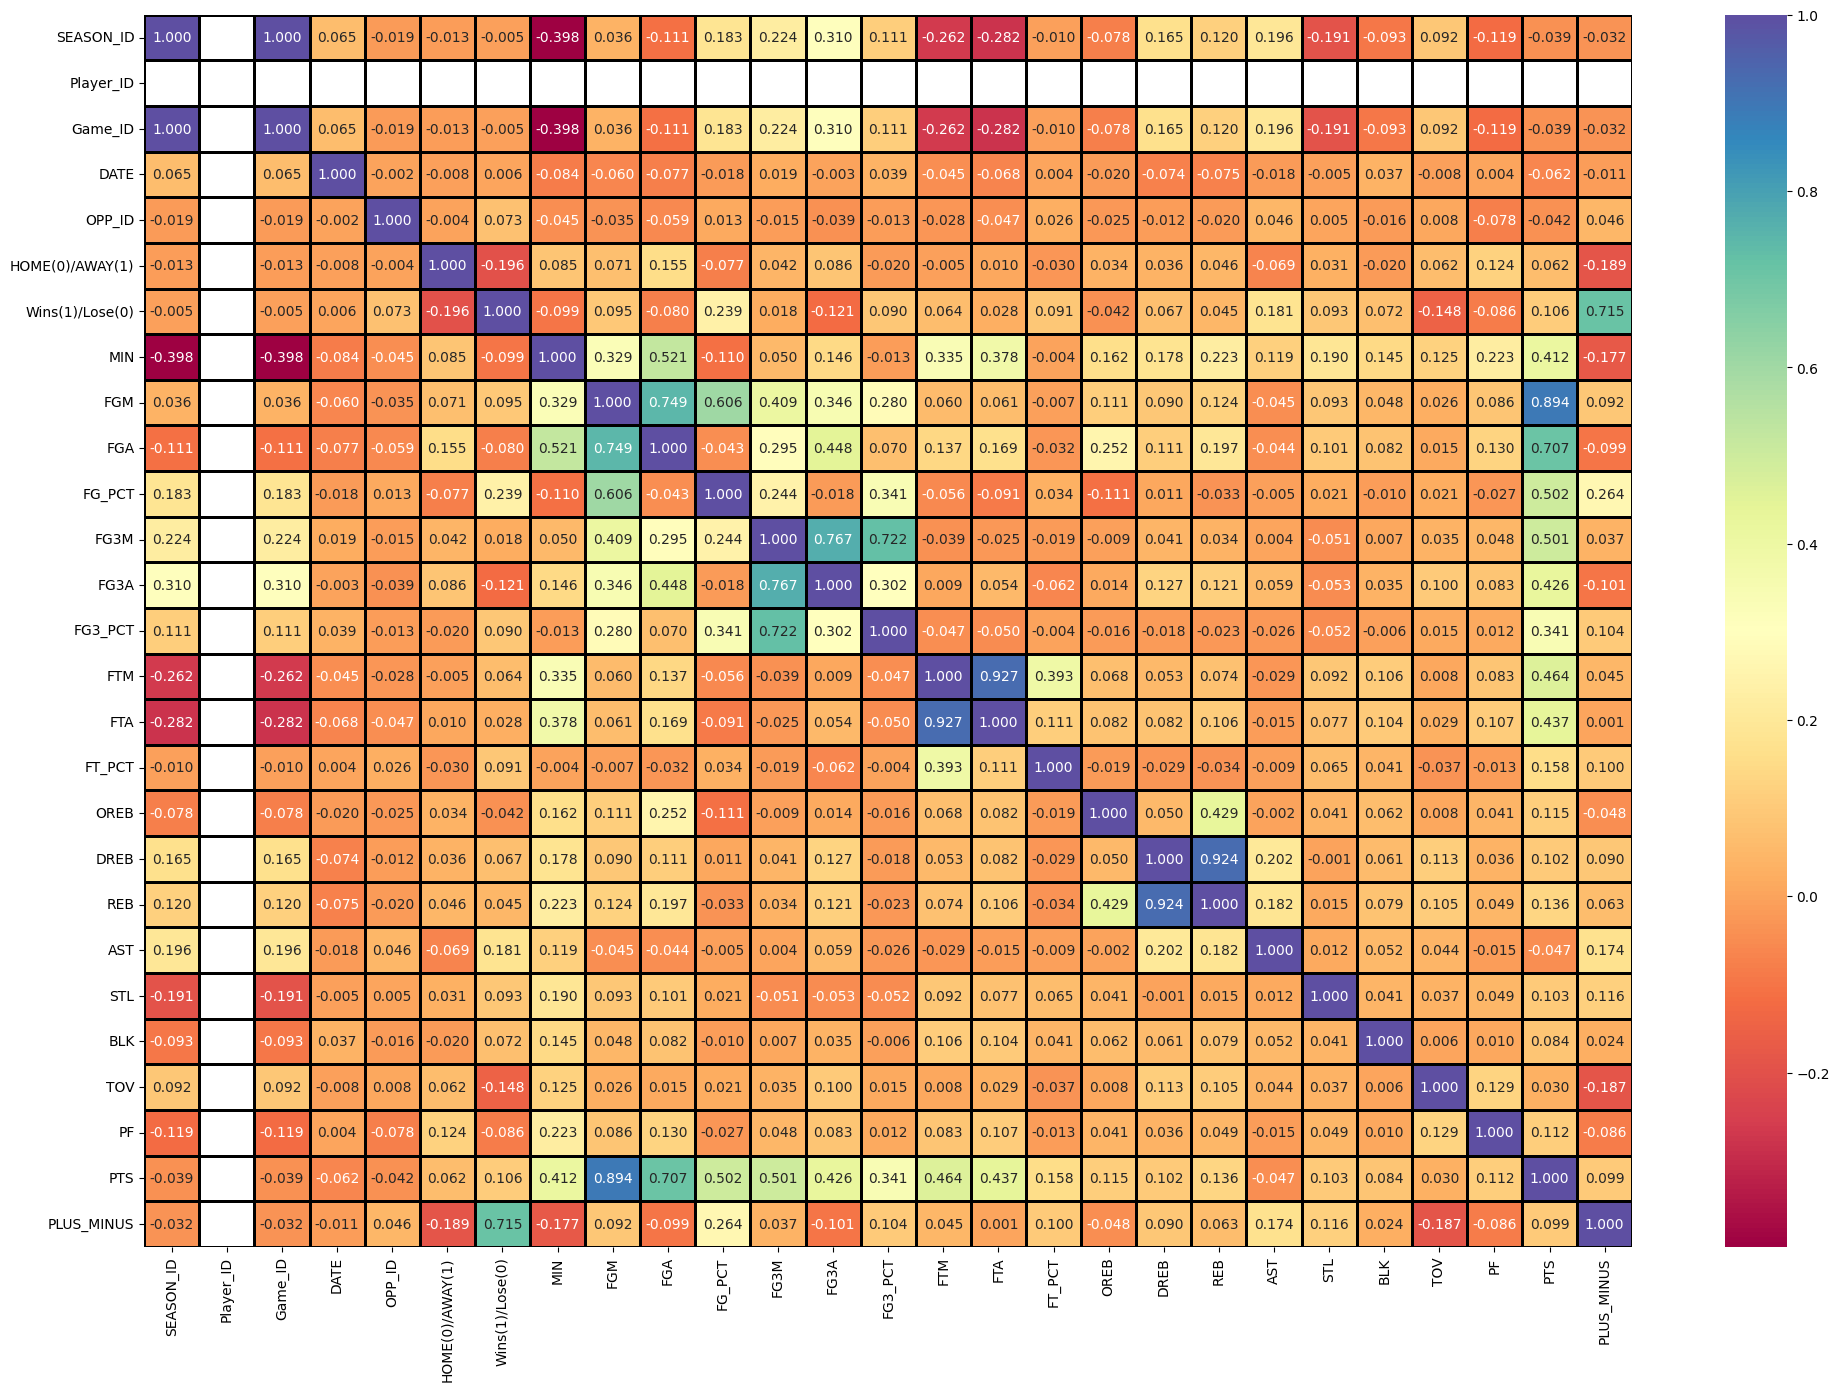

In [82]:
plt.figure(figsize = (24, 16))
sns.heatmap(numeric_career_df.corr(), annot = True, cmap = "Spectral", linewidths = 2, linecolor = "#000000", fmt='.3f')
plt.show()

In [83]:

final_df = numeric_career_df[["MIN", "FGM", "FGA", "FG_PCT", 'FG3M', "FG3A", "FTM", "FTA", "PTS"]]

### **Convert Pandas Dataframe -> Pytorch Tensor** ###

In [84]:
#Class that will convert the dataframe to a tensor
class PandasDataset(Dataset):
    def __init__(self, df, target_col):
        self.features = df.drop(target_col, axis=1).values.astype("float64")
        self.target = df[target_col].values.astype("float64")

    def __len__(self):
        return len(self.target)

    def __getitem__(self, index):
        return torch.tensor(self.features[index], dtype=torch.float), torch.tensor(self.target[index], dtype=torch.float)

# Assuming your DataFrame is called 'df' and the target column is 'target'
df = final_df
target_col = 'PTS'

dataset = PandasDataset(df, target_col)
dataloader = DataLoader(dataset, batch_size=32)


### **Implement Linear Regression Model** ###

In [85]:


# Define your model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

input_size = len(df.columns) - 1  # Number of features, excluding the target
output_size = 1  # Predicting a single value
model = LinearRegressionModel(input_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

# Training loop
epochs = 100
for epoch in range(epochs):
    for inputs, targets in dataloader:
       
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 1/100, Loss: 43.74690628051758
Epoch 2/100, Loss: 33.623268127441406
Epoch 3/100, Loss: 25.925504684448242
Epoch 4/100, Loss: 20.062286376953125
Epoch 5/100, Loss: 15.587567329406738
Epoch 6/100, Loss: 12.164950370788574
Epoch 7/100, Loss: 9.540534973144531
Epoch 8/100, Loss: 7.522503852844238
Epoch 9/100, Loss: 5.965825080871582
Epoch 10/100, Loss: 4.760782241821289
Epoch 11/100, Loss: 3.824277400970459
Epoch 12/100, Loss: 3.09330415725708
Epoch 13/100, Loss: 2.5200252532958984
Epoch 14/100, Loss: 2.068058490753174
Epoch 15/100, Loss: 1.7097400426864624
Epoch 16/100, Loss: 1.4239226579666138
Epoch 17/100, Loss: 1.1944854259490967
Epoch 18/100, Loss: 1.0090446472167969
Epoch 19/100, Loss: 0.8581174612045288
Epoch 20/100, Loss: 0.7343834638595581
Epoch 21/100, Loss: 0.6322046518325806
Epoch 22/100, Loss: 0.5472087860107422
Epoch 23/100, Loss: 0.4759904742240906
Epoch 24/100, Loss: 0.41589829325675964
Epoch 25/100, Loss: 0.3648471236228943
Epoch 26/100, Loss: 0.32119664549827576
Ep

### **Validation** ###
With the model loss very close to 0 we see our model is very accurate and close to reality. Now I can validate the model by inputing a dataset it has not seen before. In the screen shot below I inputed the player's average statline. The model should output a number close to 26 PTS.

<center>
<img src="/home/jovyan/work/Screenshot 2025-01-28 224916.png" width="40%" alt="LDA illustration">
</center>

In [86]:

# Average statline dataset that will inputed
d = {'MIN': [35.9], 'FGM': [10.0], 'FGA':[ 17.7], 'FG_PCT': [.565], 'FG3M': [1.3], 'FG3A': [4.3], 'FTM': [4.7], 'FTA': [6.4]}
df = pd.DataFrame(data=d)
df = df.values.astype("float64")
new_data = torch.tensor(df, dtype= torch.float)


In [87]:
model.eval()

LinearRegressionModel(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

### **Prediction** ###

The model outputs a value very close to the correct answer!! (Basically correct)

In [88]:
# Make prediction on the new data
predictions = model(new_data)
print(predictions)

tensor([[25.9680]], grad_fn=<AddmmBackward0>)


### **Conclusion** ###

The development of the NBA player stats prediction model using linear regression has been successfully completed. The model achieved a loss very close to 0.02233 in predicting a player's points for a single game. This result indicates that the model provides a solid foundation for predicting player performance with reasonable accuracy. However, there is still room for improvement. In future iterations, I plan to implement more advanced machine learning models, such as  neural networks, to enhance predictive accuracy and capture more complex patterns in the data. Further optimization through feature engineering, hyperparameter tuning, and additional data sources will help refine the model’s performance. By continuously improving and expanding on the current approach, this project aims to develop a more robust and precise prediction system for NBA player statistics.